In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *  # import the vision module
from fastai.metrics import error_rate  # import our evaluation metric
import zipfile # import module to unzip the data
import urllib.request
import os
import matplotlib.pyplot as plt
import PIL
import numpy as np
import re
import pandas as pd
import shutil
from sklearn.model_selection import StratifiedShuffleSplit
import random
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [ ]:
!unzip /content/drive/MyDrive/datasetsentinel3.zip

In [ ]:
DATASET = '/content/datasetsentinel3'

LABELS = os.listdir(DATASET)
print(LABELS)

['Highway', 'Forest', 'HerbaceousVegetation', 'River', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'Pasture', 'Residential', 'SeaLake']


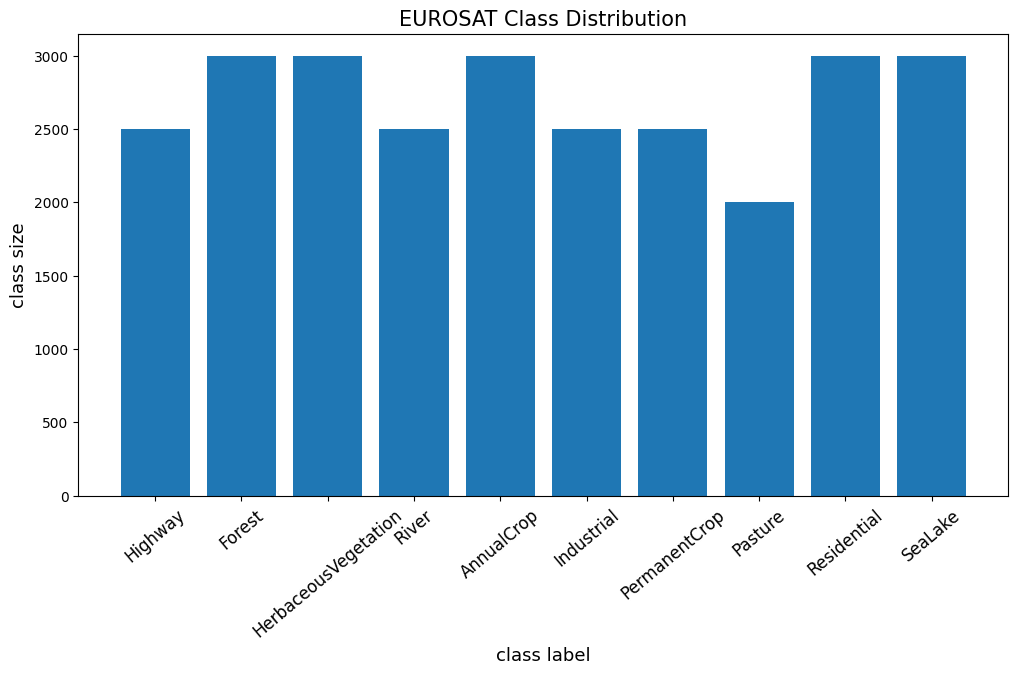

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

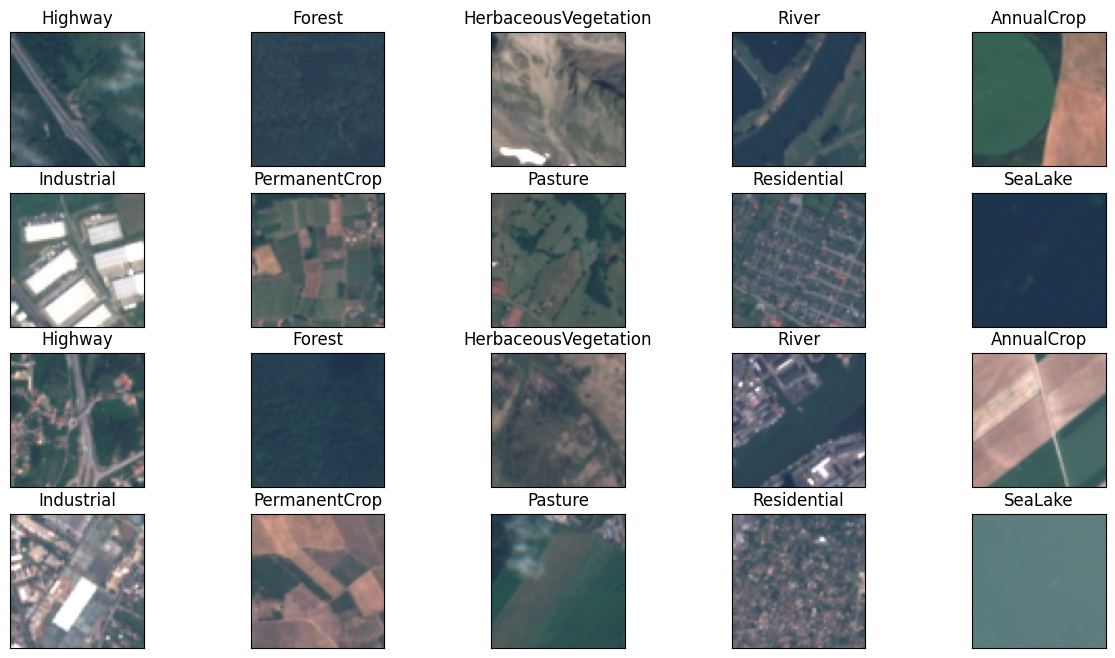

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_10.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_20.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [ ]:

train = '/content/datasetsentinel3/train'
test = '/content/datasetsentinel3/test'
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (train, test):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:

    if not os.path.exists(os.path.join(train, l)):
        os.mkdir(os.path.join(train, l))

    if not os.path.exists(os.path.join(test, l)):
        os.mkdir(os.path.join(test, l))

In [ ]:
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):

    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/content/datasetsentinel3','/content/datasetsentinel3/train', i) for i in train_paths]
    new_test_paths = [re.sub('/content/datasetsentinel3','/content/datasetsentinel3/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))

    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('/content/datasetsentinel3/train/', '/content/datasetsentinel3/test', i[1])):
                shutil.copy(i[0], i[1])

#     print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('train', 'test', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|██████████| 5400/5400 [00:01<00:00, 2853.85it/s]


In [ ]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=train,
    target_size=(64, 64),
    batch_size=32,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=test,
    target_size=(64, 64),
    batch_size=32,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
np.save('class_indices', train_generator.class_indices)

In [ ]:
# Using image data generator api in keras for making image dataset
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=train,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=test,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

tf.config.set_soft_device_placement(True)

In [ ]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):

    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet',
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet',
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet',
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)


    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet',
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet',
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)


    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])

    return model

def plot_history(history):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.show();

def display_results(y_true, y_preds, class_labels):

    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)

    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds),
                            columns=class_labels,
                            index=class_labels)
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

In [ ]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                             

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//32
N_VAL_STEPS = test_generator.samples//32
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='/Users/anukratisharma/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=10,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)


<ipython-input-43-e9d96faa5e4b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50_history = resnet50_model.fit_generator(train_generator,


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 3.7528 - categorical_accuracy: 0.1459
Epoch 1: val_categorical_accuracy improved from -inf to 0.22005, saving model to /Users/anukratisharma/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
100/100 [==============================] - 178s 2s/step - loss: 3.7528 - categorical_accuracy: 0.1459 - val_loss: 2.0563 - val_categorical_accuracy: 0.2201
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 2.0370 - categorical_accuracy: 0.2147
Epoch 2: val_categorical_accuracy improved from 0.22005 to 0.28144, saving model to /Users/anukratisharma/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5
100/100 [==============================] - 218s 2s/step - loss: 2.0370 - categorical_accuracy: 0.2147 - val_loss: 1.8992 - val_categorical_accuracy: 0.2814
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.9669 - categorical_accuracy: 0.2303
Epoch 3: val_categorical_accuracy d

In [ ]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('/Users/anukratisharma/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=10,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

Epoch 1/10


<ipython-input-45-a404be0c0d0f>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50_history = resnet50_model.fit_generator(train_generator,


100/100 [==============================] - ETA: 0s - loss: 2.0278 - categorical_accuracy: 0.6313
Epoch 1: val_categorical_accuracy did not improve from 0.35063
100/100 [==============================] - 874s 9s/step - loss: 2.0278 - categorical_accuracy: 0.6313 - val_loss: 114.9259 - val_categorical_accuracy: 0.0930 - lr: 1.0000e-04
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.6778 - categorical_accuracy: 0.8019
Epoch 2: val_categorical_accuracy did not improve from 0.35063
100/100 [==============================] - 845s 8s/step - loss: 0.6778 - categorical_accuracy: 0.8019 - val_loss: 97.0203 - val_categorical_accuracy: 0.0917 - lr: 1.0000e-04
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5717 - categorical_accuracy: 0.8372
Epoch 3: val_categorical_accuracy did not improve from 0.35063
100/100 [==============================] - 773s 8s/step - loss: 0.5717 - categorical_accuracy: 0.8372 - val_loss: 22.8287 - val_categorical_accuracy:

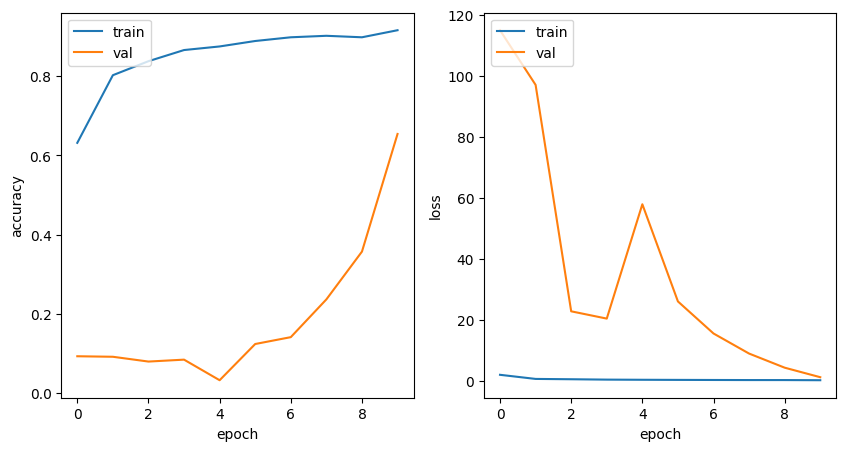

In [ ]:
plot_history(resnet50_history)

In [ ]:
resnet50_model.load_weights('/Users/anukratisharma/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory='/content/datasetsentinel3/test',
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


<ipython-input-50-bb115b591be8>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.63
Global F2 Score: 0.63


,Precision,Recall,F-Score,Support
AnnualCrop,0.535282,0.885000,0.667085,600.0
Forest,0.990385,0.171667,0.292614,600.0
HerbaceousVegetation,0.322917,0.981667,0.485974,600.0
Highway,0.919231,0.478000,0.628947,500.0
Industrial,0.992908,0.280000,0.436817,500.0
Pasture,0.949612,0.612500,0.744681,400.0
PermanentCrop,0.851301,0.458000,0.595579,500.0
Residential,0.845339,0.665000,0.744403,600.0
River,0.951289,0.664000,0.782097,500.0
SeaLake,0.813953,0.991667,0.894065,600.0


In [ ]:
resnet50_model.save('/Users/anukratisharma/Downloads/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

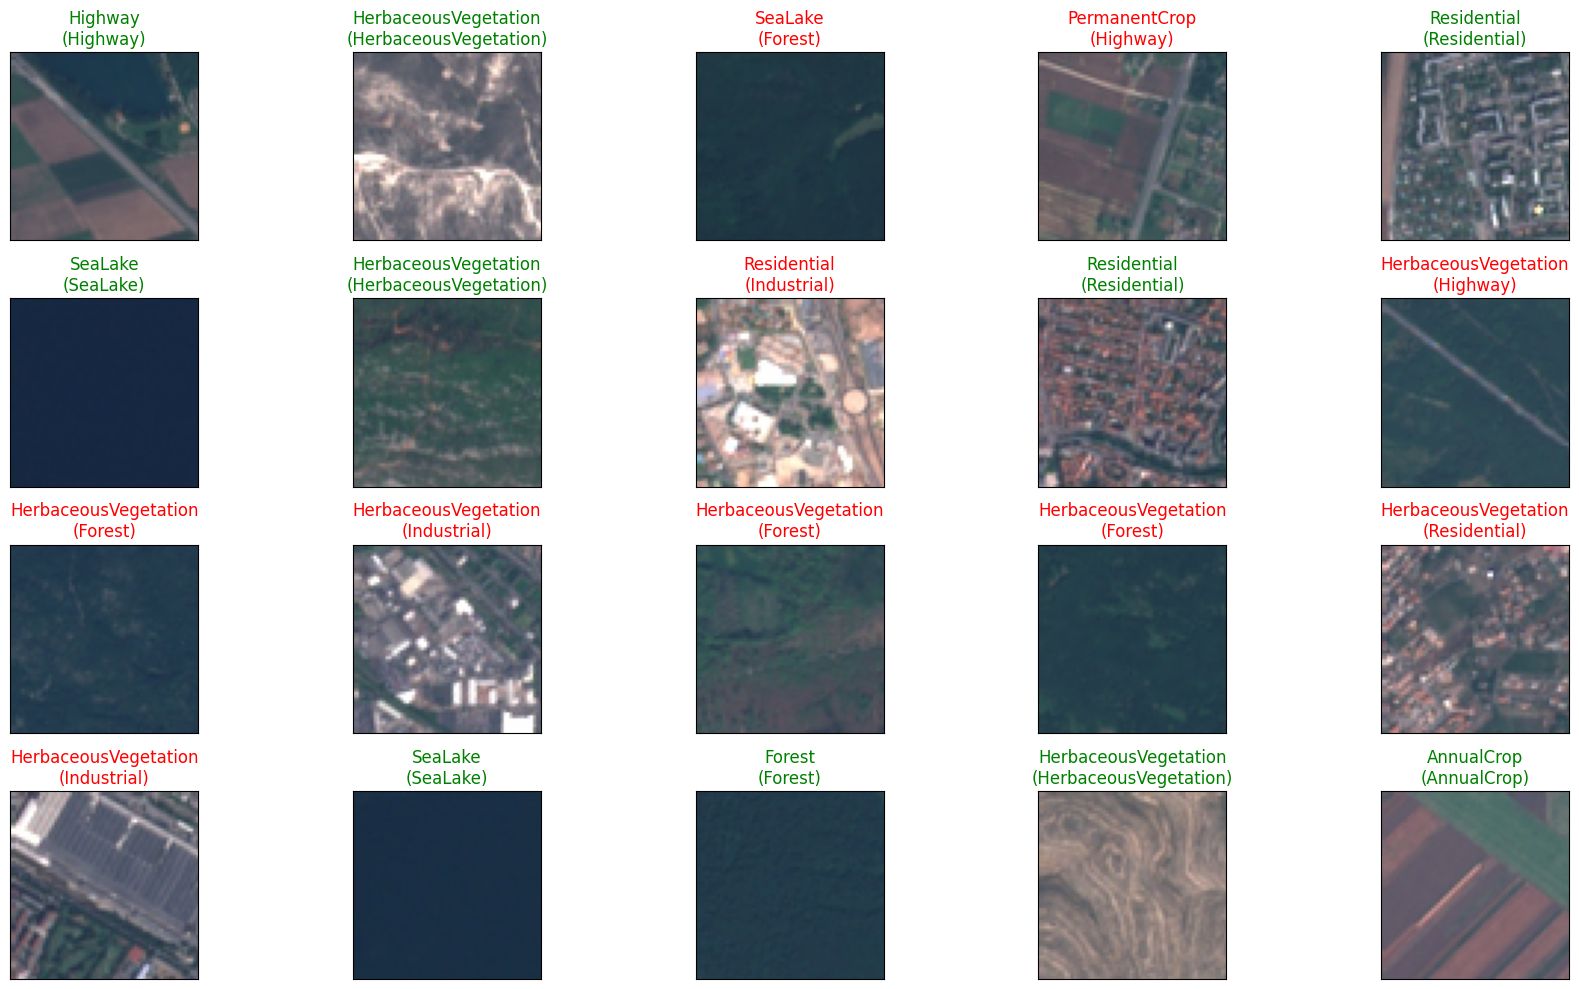

In [ ]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)